<a href="https://colab.research.google.com/github/siddley1001/CodeCademy-Capstone-Project/blob/master/Dating_Capstone_Project_%5BExploratory_Data_Analysis%5D_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import relevant libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime
import re
from sortedcontainers import SortedDict

%matplotlib inline

# import missingno as msno

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Create Helper Functions

In [3]:
def map_colors(df, keyword):
    '''Creates a color dictionary based on keyword in dataframe features'''
    color_map = {}
    
    for feature in df.columns:
        if keyword in feature:
            color_map[feature] = '#62eb96' #emerald green for essay colors
        else:
            color_map[feature] = '#eb62b7' #pink otherwise
    return color_map

def draw_missing_data_table(df):
    ''' Returns a table of % missing from each feature column in the input dataframe'''
    total = df.isnull().sum().sort_values(ascending = False)
    percent = (df.isnull().sum()/ df.isnull().count()).sort_values(ascending = False)
    missing_data = pd.concat([total, percent], axis = 1, keys = ['Total','Percent Missing'])
    final_missing = missing_data.reset_index().rename(columns = 
                                                      {'index': 'feature', 
                                                       'Total': 'total null', 
                                                       'Percent Missing': '% of null values in the column'})
    return final_missing

def plot_viz(df, feature, barh = True, ascending = True, figsize = (12, 5)):
    ''' Returns barplot of the feature's value counts from its respective dataframe
    --------------------------------------------------------------------------------
    Params
    - barh: Returns either a horizontal or vertical bar plots
    - ascending: Adjusts how values are ordered in the plot
    - figsize: Adjusts the Size of the plot
    '''
    df[feature].value_counts(ascending = ascending).plot(kind = 'barh', figsize = figsize)
    
    plt.title('Survey Responses of the ' + feature + ' feature')
    plt.xlabel('Survey Counts')
    plt.ylabel(feature + 's')

    if barh == False:
        df[feature].value_counts(ascending = ascending).plot(kind = 'bar', figsize = figsize)
        
        plt.title('Survey Responses of ' + feature + ' feature')
        plt.xlabel(feature + 's')
        plt.ylabel('Survey Counts')

In [4]:
def countFreq(list):
    freq_dic = {}
    for hour in list:
        freq_dic[hour] = list.count(hour)
    return(freq_dic)

# Load data from CSV

In [5]:
#Make a copy of the dataset so we have all the original information as we manipulate columns and values
PATH = '/content/drive/My Drive/Dating Capstone Project/'
df = pd.read_csv(PATH + 'data/profiles.csv')

#Leave the original data untouched
df_copy = df.copy()

# **Objective**: Determine the sex of the survey respondant based on text data and other relevant features.

### Understand the Distribution of the Target Feature

In [6]:
df_copy['sex'].value_counts()

m    35829
f    24117
Name: sex, dtype: int64

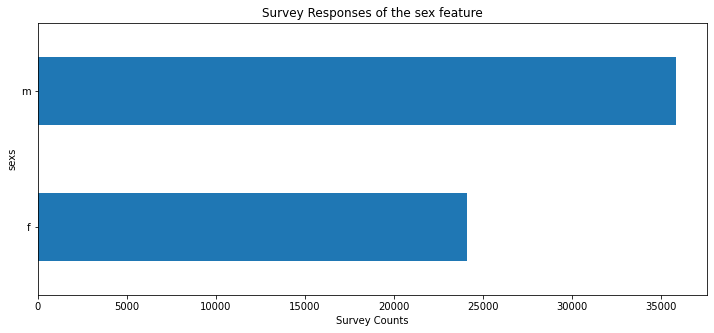

In [7]:
plot_viz(df_copy, 'sex')

# Understand the Data
- *Total*: shape, missing data, data types
- *Split*: essay and non-essay features
- *Distributions* for the features
- *Plans* for transforming feature to feed into a Classification model

## Initial EDA

In [8]:
df_copy.shape

(59946, 31)

**Summary**: Almost 60,000 observations!

In [9]:
df_copy.head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
0,22,a little extra,strictly anything,socially,never,working on college/university,about me:<br />\n<br />\ni would love to think...,currently working as an international agent fo...,making people laugh.<br />\nranting about a go...,"the way i look. i am a six foot half asian, ha...","books:<br />\nabsurdistan, the republic, of mi...",food.<br />\nwater.<br />\ncell phone.<br />\n...,duality and humorous things,trying to find someone to hang out with. i am ...,i am new to california and looking for someone...,you want to be swept off your feet!<br />\nyou...,"asian, white",75.0,-1,transportation,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism and very serious about it,m,gemini,sometimes,english,single
1,35,average,mostly other,often,sometimes,working on space camp,i am a chef: this is what that means.<br />\n1...,dedicating everyday to being an unbelievable b...,being silly. having ridiculous amonts of fun w...,NaN,i am die hard christopher moore fan. i don't r...,delicious porkness in all of its glories.<br /...,NaN,NaN,i am very open and will share just about anyth...,NaN,white,70.0,80000,hospitality / travel,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism but not too serious about it,m,cancer,no,"english (fluently), spanish (poorly), french (...",single
2,38,thin,anything,socially,NaN,graduated from masters program,"i'm not ashamed of much, but writing public te...","i make nerdy software for musicians, artists, ...",improvising in different contexts. alternating...,my large jaw and large glasses are the physica...,okay this is where the cultural matrix gets so...,movement<br />\nconversation<br />\ncreation<b...,NaN,viewing. listening. dancing. talking. drinking...,"when i was five years old, i was known as ""the...","you are bright, open, intense, silly, ironic, ...",NaN,68.0,-1,NaN,2012-06-27-09-10,"san francisco, california",NaN,straight,has cats,NaN,m,pisces but it doesn&rsquo;t matter,no,"english, french, c++",available
3,23,thin,vegetarian,socially,NaN,working on college/university,i work in a library and go to school. . .,reading things written by old dead people,playing synthesizers and organizing books acco...,socially awkward but i do my best,"bataille, celine, beckett. . .<br />\nlynch, j...",NaN,cats and german philosophy,NaN,NaN,you feel so inclined.,white,71.0,20000,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,NaN,m,pisces,no,"english, german (poorly)",single
4,29,athletic,NaN,socially,never,graduated from college/university,hey how's it going? currently vague on the pro...,work work work work + play,creating imagery to look at:<br />\nhttp://bag...,i smile a lot and my inquisitive nature,"music: bands, rappers, musicians<br />\nat the...",NaN,NaN,NaN,NaN,NaN,"asian, black, other",66.0,-1,artistic / musical / writer,2012-06-27-21-26,"san francisco, california",NaN,straight,likes dogs and likes cats,NaN,m,aquarius,no,english,single


In [10]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59946 entries, 0 to 59945
Data columns (total 31 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          59946 non-null  int64  
 1   body_type    54650 non-null  object 
 2   diet         35551 non-null  object 
 3   drinks       56961 non-null  object 
 4   drugs        45866 non-null  object 
 5   education    53318 non-null  object 
 6   essay0       54458 non-null  object 
 7   essay1       52374 non-null  object 
 8   essay2       50308 non-null  object 
 9   essay3       48470 non-null  object 
 10  essay4       49409 non-null  object 
 11  essay5       49096 non-null  object 
 12  essay6       46175 non-null  object 
 13  essay7       47495 non-null  object 
 14  essay8       40721 non-null  object 
 15  essay9       47343 non-null  object 
 16  ethnicity    54266 non-null  object 
 17  height       59943 non-null  float64
 18  income       59946 non-null  int64  
 19  job 

## Total Missing Data

In [11]:
missing_features = draw_missing_data_table(df_copy)
missing_features

,feature,total null,% of null values in the column
0,offspring,35561,0.593217
1,diet,24395,0.406950
2,religion,20226,0.337404
3,pets,19921,0.332316
4,essay8,19225,0.320705
5,drugs,14080,0.234878
6,essay6,13771,0.229723
7,essay9,12603,0.210239
8,essay7,12451,0.207704
9,essay3,11476,0.191439


### Visualization of *missing data* by feature

In [12]:
essay_color_map = map_colors(df_copy, 'essay')

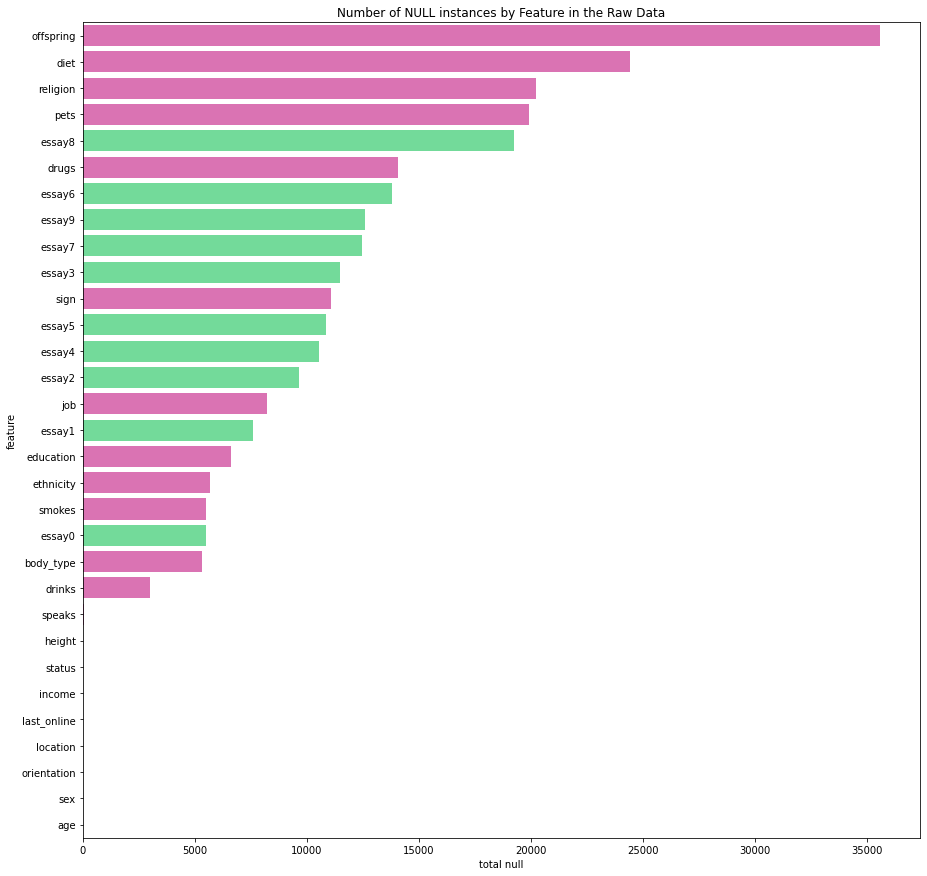

In [13]:
plt.figure(figsize = (15,15))
plt.title('Number of NULL instances by Feature in the Raw Data')
sns.barplot(y = 'feature', x = 'total null', data = missing_features, palette= essay_color_map)
# Include legend: 

### Correlation Matrix for Numerical Features

Text(0.5, 1.0, 'Correlation of Numerical Features')

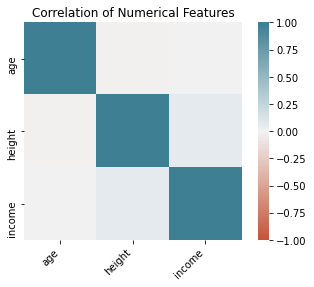

In [14]:
corr = df_copy.corr()
ax = sns.heatmap(corr, vmin = -1, vmax= 1, center = 0, cmap = sns.diverging_palette(20,220, n=200), square = True)
ax.set_xticklabels(
    ax.get_xticklabels(), rotation= 45, horizontalalignment = 'right'
)
plt.title('Correlation of Numerical Features')

**Summary**: We can see that there is a *faint* correlation (~.25) between **height** and **income**

## *Understand* numerical features:
- Correlations
- Distributions
- Outliers

### Age

In [15]:
df.age.describe()

count    59946.000000
mean        32.340290
std          9.452779
min         18.000000
25%         26.000000
50%         30.000000
75%         37.000000
max        110.000000
Name: age, dtype: float64

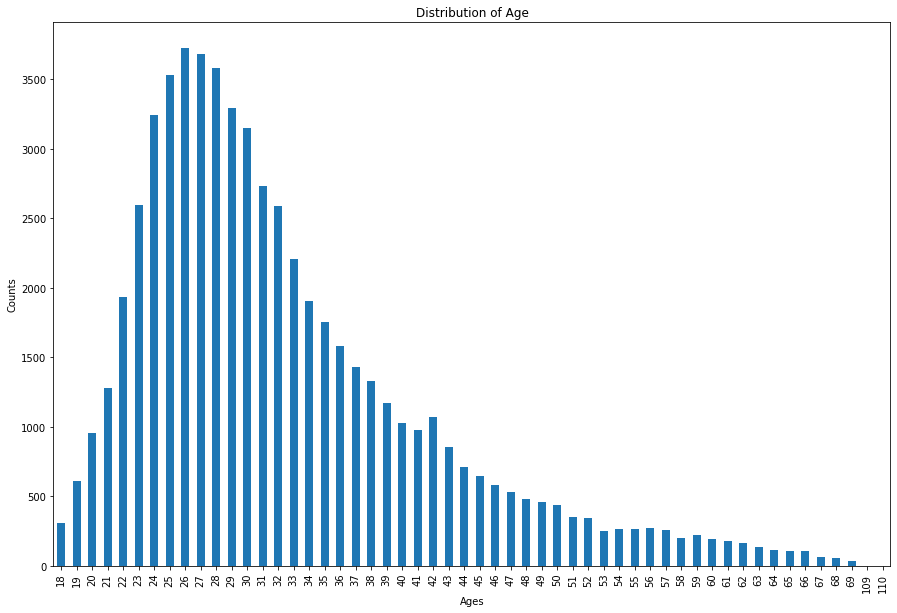

In [16]:
plt.figure(figsize = (15,10))
plt.title('Distribution of Age')
plt.xlabel('Ages')
plt.ylabel('Counts')
df_copy.age.value_counts().sort_index().plot(kind = 'bar')

**Summary**: 
- No minors since all ages are >= 18
- Distribution of Ages is *right-skewed* where there are **2 outliers** of ages 109 and 110.
- Use the Boxcox transformation to realign the distribution

### Height

In [17]:
df.height.describe()

count    59943.000000
mean        68.295281
std          3.994803
min          1.000000
25%         66.000000
50%         68.000000
75%         71.000000
max         95.000000
Name: height, dtype: float64

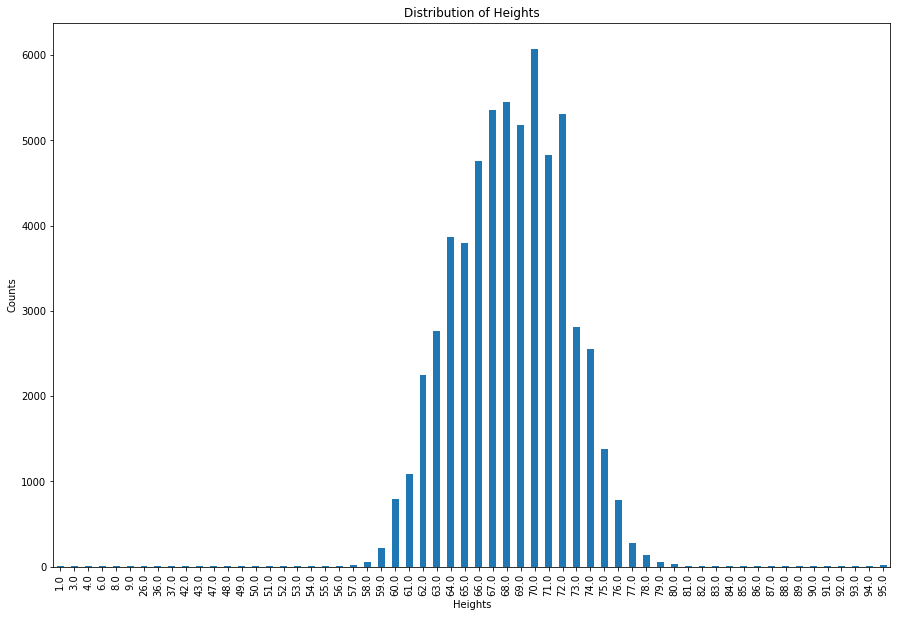

In [18]:
plt.figure(figsize = (15,10))
plt.title('Distribution of Heights')
plt.xlabel('Heights')
plt.ylabel('Counts')
df.height.value_counts().sort_index().plot(kind = 'bar')

In [19]:
df_copy.loc[ df_copy['height'] < 48].head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
7098,28,average,anything,socially,sometimes,NaN,i am a full time student attending state unive...,"besides being a full time student, i work part...",lots of things,my eyes and my smile,i love reading so there's probably too many bo...,pizza<br />\ntravelling<br />\nblue gatorade<b...,the future,working or catching up with friends,i am quite clumsy,you'd like to meet someone new who is fun and ...,hispanic / latin,36.0,-1,NaN,2012-06-30-03-59,"san francisco, california",NaN,straight,NaN,NaN,m,NaN,sometimes,english,single
7786,24,used up,mostly anything,often,never,graduated from space camp,i've recently moved to the bay and am slightly...,just got done with school. can't say it was an...,paying attention during a conversation; keepin...,"itchy feet and fading smiles.<br />\nalso, i s...","if i knew how to read, i probably wouldn't.<br...",1. air<br />\n2. water<br />\n3. food<br />\n4...,grammar and punctuation.,either reading at home or overwhelmed.,i once stared back at the big brother until it...,you think you can outweird me; you're good at ...,other,43.0,-1,hospitality / travel,2011-11-11-00-04,"el cerrito, california",doesn&rsquo;t want kids,straight,dislikes dogs and likes cats,atheism and laughing about it,m,aquarius and it matters a lot,no,"english (poorly), french (poorly)",single
12193,30,NaN,mostly vegetarian,socially,NaN,graduated from space camp,"well, hello and thank you for stopping by my g...","i mostly try to be good at what i do, maintain...",folding laundry.,perhaps my eyes? i'm told they are a unique co...,i really like memoirs of folks who have persev...,NaN,how many more minutes until i can get into my ...,relaxing!,"when i was a kid, i poured myself a glass of r...",you are easy going and big loving.<br />\nyou ...,white,8.0,-1,medicine / health,2012-06-30-03-02,"berkeley, california",doesn&rsquo;t have kids,straight,likes dogs and likes cats,judaism but not too serious about it,f,taurus but it doesn&rsquo;t matter,no,english,single
12330,50,athletic,mostly anything,rarely,never,graduated from space camp,"i'm fiercely independent, highly motivated, cr...",NaN,NaN,my body,NaN,NaN,NaN,tango dancing,NaN,"if you are a gem, not a trophy--the stone's co...",white,36.0,-1,retired,2012-02-15-18-17,"san francisco, california",doesn&rsquo;t have kids,straight,has dogs and likes cats,christianity but not too serious about it,m,NaN,no,english (fluently),single
18583,35,average,NaN,socially,sometimes,NaN,"well, i am a dork and i like it! i like <a cla...",currently working at stanford.<br />\ngoing to...,"<p><a class=""ilink"" href=""/interests?i=paintin...",you tell me.,"authors:paulo coelho, dostoevsky,kafka, tom ro...","<a class=""ilink"" href=""/interests?i=coffee"">co...",all the random coincidences that seem to happe...,lately? studying classic films in my netflix q...,i like abba,"you like being spontaneous, you play music, si...",white,36.0,150000,entertainment / media,2012-06-30-14-40,"san mateo, california",NaN,straight,likes dogs and likes cats,other but not too serious about it,m,leo and it&rsquo;s fun to think about,no,"english (fluently), esperanto (poorly)",single


In [20]:
df_copy.loc[df_copy['height'] > 84].head()

,age,body_type,diet,drinks,drugs,education,essay0,essay1,essay2,essay3,essay4,essay5,essay6,essay7,essay8,essay9,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status
402,22,jacked,mostly anything,often,sometimes,graduated from college/university,"i wasn't like every other kid, you know, who d...","chick 1: pr, chick 2: biz dev tech startup<br ...","using wikipedia, painting rocks, paddle boardi...",lips and hair and charming wit (both),"armageddon, bob dylan, happy feet 2, mac &amp;...","lust, gluttony, pride, sloth, wrath, greed, envy",enterprise-facing cloud storage products,making calzones and doing body shots off mario...,NaN,you think you can handle one of us... and has ...,white,91.0,150000,sales / marketing / biz dev,2012-06-29-22-25,"san francisco, california",NaN,straight,likes dogs and likes cats,other and laughing about it,f,NaN,no,"english, afrikaans (okay), french (fluently), ...",single
2569,26,NaN,strictly other,NaN,NaN,graduated from college/university,about two months ago i bought a 10-pack of pla...,wading thigh-high into the autism spectrum.,nope!,"the ""kick me"" sign on my back as i run away fr...","books: envy, the master and margarita, a confe...","i hardly ""do"" by any measure.","retinol, dha, epa, k2. getting my chupacabra h...",sure as hell not skipping tuba practice.,the books on that air-tight list of favorite b...,"you aren't necessarily the first one to yell ""...",native american,95.0,-1,NaN,2012-06-29-13-41,"san francisco, california",NaN,straight,NaN,NaN,m,taurus,NaN,english,single
3016,30,fit,NaN,socially,never,graduated from law school,spontaneous guy with a get-up-and-go kind of m...,"this is an incredibly difficult question, if y...",im pretty good at getting what i want. if i de...,"my hair... don't get me wrong, it looks almost...",too much to go into here..,"1. cuddling - yes, i said it ;)<br />\n2. art<...",i think a lot about my career and working towa...,this is a tough one. either i am truly pumped ...,my eyes can get a little watery during emotion...,you've caught yourself smiling at any point wh...,white,95.0,-1,law / legal services,2012-04-23-23-36,"san francisco, california",NaN,straight,NaN,NaN,m,aquarius but it doesn&rsquo;t matter,no,english (fluently),single
6356,26,overweight,mostly anything,not at all,never,graduated from high school,NaN,NaN,picking peoples outfits when they ha any event...,i'm funny outgoing fashinista,my favorite movie is footloose the secret gard...,i can't be without my family i can't go uot wi...,NaN,to the movies,NaN,you are interesting in me,white,87.0,20000,other,2011-12-26-22-05,"san mateo, california",NaN,straight,has dogs and dislikes cats,christianity and very serious about it,f,taurus but it doesn&rsquo;t matter,no,english (fluently),single
8089,55,rather not say,NaN,desperately,often,dropped out of high school,"my life has been a gigantic failure, and a hug...","as little as possible, so as not to use up ene...",smoking<br />\ndrinking<br />\ncheating<br />\...,my charm.<br />\nmy fourth leg.<br />\n(someho...,anything i am in.,guinness.<br />\nscotch.<br />\nvodka.<br />\n...,me.<br />\n<br />\nand what others like so muc...,"oh, i can never remember that. friday nights. ...",i nearly bought a hybrid.,you think i am god's gift to womankind.,"asian, middle eastern, black, native american,...",95.0,20000,unemployed,2012-04-19-07-50,"berkeley, california","has a kid, but doesn&rsquo;t want more",straight,dislikes dogs and dislikes cats,other and very serious about it,m,sagittarius but it doesn&rsquo;t matter,when drinking,english,single


In [21]:
df.height.value_counts().sort_index()

1.0        1
3.0        1
4.0        1
6.0        1
8.0        1
9.0        1
26.0       1
36.0      11
37.0       2
42.0       1
43.0       2
47.0       1
48.0       2
49.0       1
50.0       2
51.0       1
52.0       1
53.0       5
54.0       3
55.0       6
56.0       8
57.0      17
58.0      53
59.0     212
60.0     791
61.0    1090
62.0    2244
63.0    2767
64.0    3865
65.0    3794
66.0    4759
67.0    5354
68.0    5449
69.0    5179
70.0    6074
71.0    4826
72.0    5315
73.0    2815
74.0    2547
75.0    1382
76.0     783
77.0     280
78.0     132
79.0      57
80.0      27
81.0      11
82.0      11
83.0      12
84.0       9
85.0       1
86.0       1
87.0       1
88.0       2
89.0       1
90.0       1
91.0       3
92.0       1
93.0       1
94.0       3
95.0      20
Name: height, dtype: int64

**Summary**: Heights have a relatively *normal distribution* centered around 5'8"(68in).
- Outliers
    - Upper Outliers: >7ft (84in)
    - Lower Outliers: <4ft (48in)
- Min and Max for Height are giveaways that the feature data lacks integrity

### Income

In [22]:
df_copy.income.describe()

count      59946.000000
mean       20033.222534
std        97346.192104
min           -1.000000
25%           -1.000000
50%           -1.000000
75%           -1.000000
max      1000000.000000
Name: income, dtype: float64

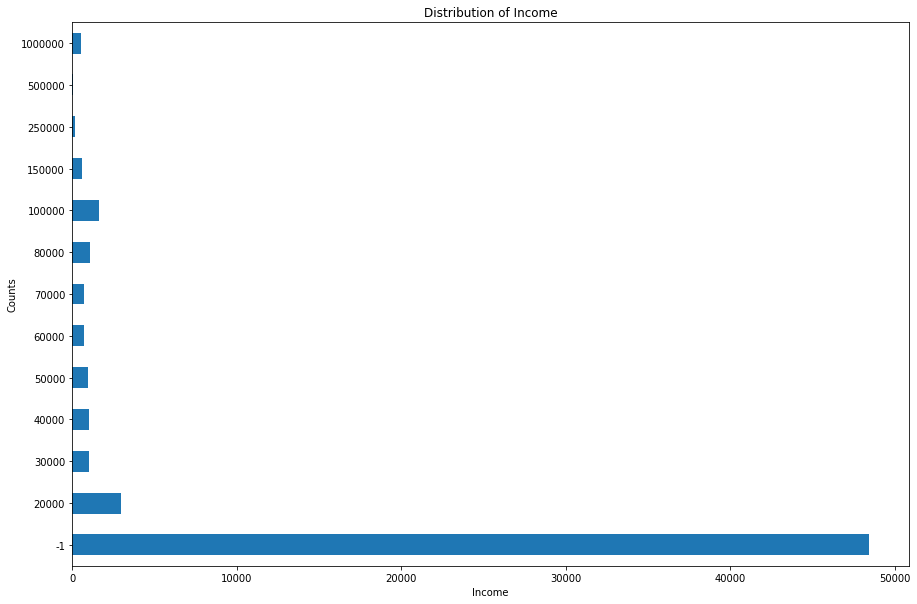

In [23]:
plt.figure(figsize = (15,10))
plt.title('Distribution of Income')
plt.xlabel('Income')
plt.ylabel('Counts')
df.income.value_counts().sort_index().plot(kind = 'barh')

In [24]:
i = df_copy.income
unreported = 100* (i.value_counts().sum() - i[i==-1].count()) / i.value_counts().sum()
print("With only {x:.2f}% of data NOT EQUAL to -1 & avaiable, one should DROP the feature.".format(x = unreported))
print('FEATURE GENERATION: Create a boolean, "unreported income" feature to feed into the model')

With only 19.19% of data NOT EQUAL to -1 & avaiable, one should DROP the feature.
FEATURE GENERATION: Create a boolean, "unreported income" feature to feed into the model


**Summary**: Overwhelming amount of unreported incomes as (-1)

## Split the data into Essay and non-essay groups for easy access

In [25]:
essay_cols = [str(x) for x in df_copy.columns if 'essay' in x]
essay_df = df_copy[essay_cols]

nonessay_cols = [str(x) for x in df_copy.columns if 'essay' not in x]
nonessay_df = df_copy[nonessay_cols]

### Non-Essay Features
UPDATE: Plot Distribution of each feature in the nonEssay dataframe.
- ~~Age~~
- Body type
- Diet
- Drinks
- Drugs
- Education
- Ethnicity
- ~~Height~~
- ~~Income~~
- Job
- Last Online
- Location
- Offspring
- Orientation
- Pets
- Religion
- ~~Sex~~
- Sign
- Smokes
- Speaks
- Status


In [26]:
nonessay_df.columns

Index(['age', 'body_type', 'diet', 'drinks', 'drugs', 'education', 'ethnicity',
       'height', 'income', 'job', 'last_online', 'location', 'offspring',
       'orientation', 'pets', 'religion', 'sex', 'sign', 'smokes', 'speaks',
       'status'],
      dtype='object')

#### Body Type

In [27]:
nonessay_df['body_type'].value_counts()

average           14652
fit               12711
athletic          11819
thin               4711
curvy              3924
a little extra     2629
skinny             1777
full figured       1009
overweight          444
jacked              421
used up             355
rather not say      198
Name: body_type, dtype: int64

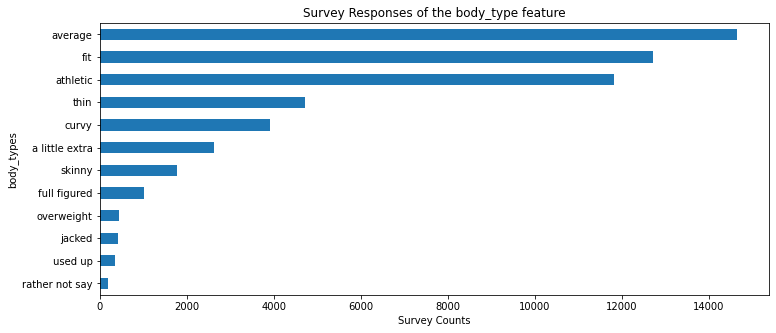

In [28]:
plot_viz(nonessay_df, 'body_type')

##### **Summary**: Majority of respondents are >= average
- Could binnerize categories with the *apply* function
    - Skinny
    - Average
    - Fat
<br> or OHE the feature

#### Diet

In [29]:
df_copy['diet'].value_counts()

mostly anything        16585
anything                6183
strictly anything       5113
mostly vegetarian       3444
mostly other            1007
strictly vegetarian      875
vegetarian               667
strictly other           452
mostly vegan             338
other                    331
strictly vegan           228
vegan                    136
mostly kosher             86
mostly halal              48
strictly halal            18
strictly kosher           18
kosher                    11
halal                     11
Name: diet, dtype: int64

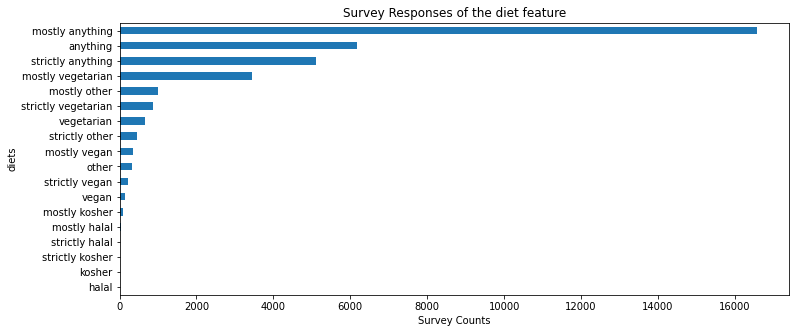

In [30]:
plot_viz(df_copy, 'diet')

##### **Summary**: Majority of respondents are OPEN to eating any type of food
Could binnerize categories with the *apply* function
    - Picky
    - Relax
<br> or OHE the feature

#### Drinks

In [31]:
df_copy['drinks'].value_counts()

socially       41780
rarely          5957
often           5164
not at all      3267
very often       471
desperately      322
Name: drinks, dtype: int64

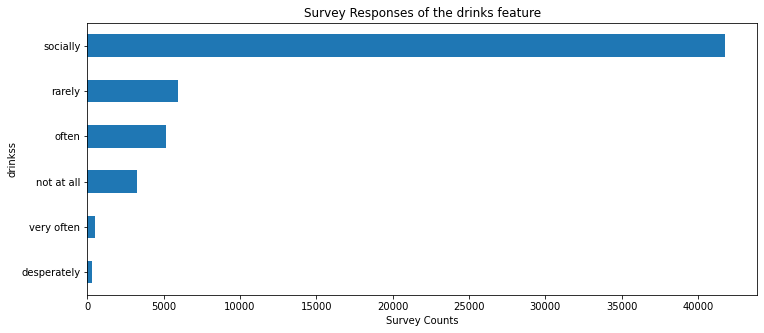

In [32]:
plot_viz(df_copy, 'drinks')

##### **Summary**: Majority of Respondents drink socially
- Could binnerize in 2 categories with the *apply* function
    - *Often* = Socially + often + very often + desperately
    - *Not Often* = rarely + not at all
<br> or OHE the feature

#### Drugs

In [33]:
df_copy['drugs'].value_counts()

never        37724
sometimes     7732
often          410
Name: drugs, dtype: int64

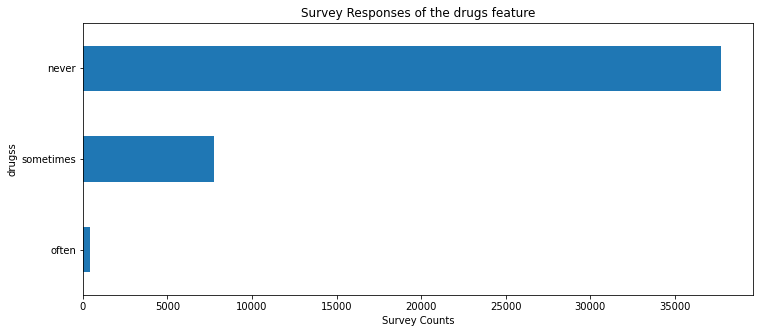

In [34]:
plot_viz(df_copy, 'drugs')

##### **Summary**: Majority of respondents never "have done/do" drugs
- Could binnerize into 2 categories with the *apply* function
    - Never -> No
    - Sometimes + Often -> Yes
<br> Turn dtype into **boolean**

#### Education

In [35]:
df_copy['education'].value_counts()

graduated from college/university    23959
graduated from masters program        8961
working on college/university         5712
working on masters program            1683
graduated from two-year college       1531
graduated from high school            1428
graduated from ph.d program           1272
graduated from law school             1122
working on two-year college           1074
dropped out of college/university      995
working on ph.d program                983
college/university                     801
graduated from space camp              657
dropped out of space camp              523
graduated from med school              446
working on space camp                  445
working on law school                  269
two-year college                       222
working on med school                  212
dropped out of two-year college        191
dropped out of masters program         140
masters program                        136
dropped out of ph.d program            127
dropped out

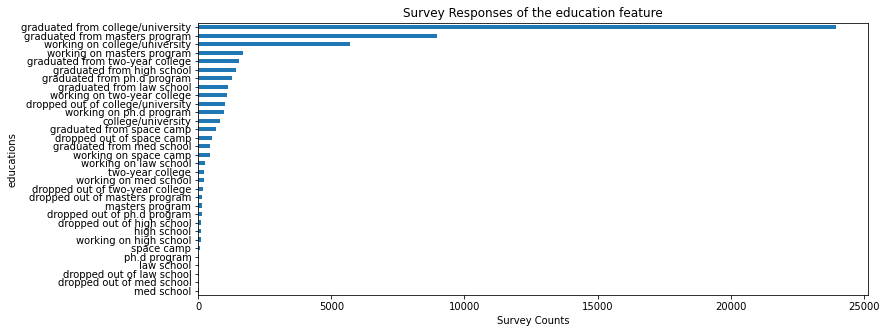

In [36]:
plot_viz(df_copy, 'education')

##### **Summary**: Majority are affiliated with a University
- Lots of different signal from this feature
    - (Y/N) Whether or not they are currently in school
    - (Y/N) Dropped out/ Graduated
    - (OHE) Education affiliate:
        - High School degree/ Space Camp
        - 2 yr Program
        - University
        - Graduate (Med school, pHD, Masters)
<br> or OHE the feature

#### Ethnicity

In [37]:
df_copy['ethnicity'].value_counts().head(30)

white                                                                                                      32831
asian                                                                                                       6134
hispanic / latin                                                                                            2823
black                                                                                                       2008
other                                                                                                       1706
hispanic / latin, white                                                                                     1301
indian                                                                                                      1077
asian, white                                                                                                 811
white, other                                                                                    

##### **Summary**: There are many multicultural respondents
- Create "multiracial" categories with the *apply* function
    - (OHE) all the Single Ethnicities
    - A multiracial ethnicity feature if >= 3 races


#### Job

In [38]:
df_copy['job'].value_counts()

other                                7589
student                              4882
science / tech / engineering         4848
computer / hardware / software       4709
artistic / musical / writer          4439
sales / marketing / biz dev          4391
medicine / health                    3680
education / academia                 3513
executive / management               2373
banking / financial / real estate    2266
entertainment / media                2250
law / legal services                 1381
hospitality / travel                 1364
construction / craftsmanship         1021
clerical / administrative             805
political / government                708
rather not say                        436
transportation                        366
unemployed                            273
retired                               250
military                              204
Name: job, dtype: int64

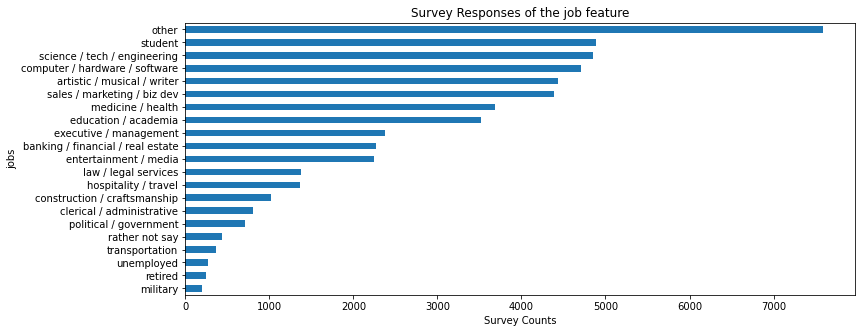

In [39]:
plot_viz(df_copy, 'job')

##### **Summary**: Majority don't specify job industry or are students
- (OHE) all the'industries'
- **NOTE** how this changes once survey respondants are dropped


#### Last Online

In [40]:
df_copy['last_online'] = df_copy['last_online'].astype('string') # Change dtype to a string to convert into Datetime
df_copy['last_online'] = pd.to_datetime(df_copy['last_online'], format = "%Y-%m-%d-%H-%M")
# df_copy['last_online'].describe()

In [41]:
df_copy['last_online'].head()

0   2012-06-28 20:30:00
1   2012-06-29 21:41:00
2   2012-06-27 09:10:00
3   2012-06-28 14:22:00
4   2012-06-27 21:26:00
Name: last_online, dtype: datetime64[ns]

###### Create a Table of Dates and Times that users Logged on

In [42]:
dt_table = pd.DataFrame()
dt_table['Date'] = df_copy['last_online'].dt.date
dt_table['Time'] = df_copy['last_online'].dt.time
sorted = dt_table.sort_values(by = 'Date')
sorted

,Date,Time
48850,2011-06-27,19:22:00
9849,2011-06-27,08:22:00
16219,2011-06-27,18:19:00
57254,2011-06-27,14:18:00
30652,2011-06-27,23:21:00
...,...,...
55568,2012-07-01,04:09:00
55577,2012-07-01,01:27:00
46300,2012-07-01,01:27:00
55591,2012-07-01,07:14:00


###### Find the most Frequent Hours users logged on
- Create the hour count dictionary


In [43]:
hours = [dt_table.Time[x].hour for x in range(len(dt_table.Time))]
c = countFreq(hours)

In [44]:
c

{0: 3329,
 1: 2225,
 2: 1409,
 3: 786,
 4: 525,
 5: 550,
 6: 826,
 7: 1461,
 8: 2154,
 9: 2480,
 10: 2565,
 11: 2527,
 12: 2455,
 13: 2459,
 14: 2585,
 15: 2691,
 16: 2653,
 17: 2920,
 18: 3082,
 19: 3367,
 20: 3698,
 21: 4267,
 22: 4685,
 23: 4247}

In [45]:
sort_hours = SortedDict(c)
sort_hours

SortedDict({0: 3329, 1: 2225, 2: 1409, 3: 786, 4: 525, 5: 550, 6: 826, 7: 1461, 8: 2154, 9: 2480, 10: 2565, 11: 2527, 12: 2455, 13: 2459, 14: 2585, 15: 2691, 16: 2653, 17: 2920, 18: 3082, 19: 3367, 20: 3698, 21: 4267, 22: 4685, 23: 4247})

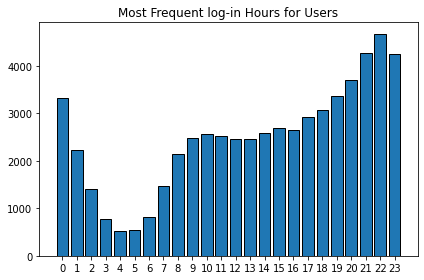

In [46]:
x = list(sort_hours.keys())
y = list(sort_hours.values())
plt.bar(x = x, height = y, edgecolor = "black", tick_label = x)
plt.title("Most Frequent log-in Hours for Users")
plt.tight_layout()

##### **Summary**: Survey responses spanned ~1 year | Essentially JULY2011 - July2012
- **NOTE:** Need to Convert the feature to 'datetime[ns]'
- Split into date and time columns; and then drop this feature
- Analyze Information:
    - Dates
        - Most Frequent months
        - Most Frequent Weekday
    - Times
        - Which 1/3 of the Day is most popular: Morning, Afternoon, Evening
        - Popular time by the hour


#### Location

##### Create new City and State Features on df_copy

In [47]:
df_copy['City'] = df_copy['location'].apply(lambda location: location.split(sep = ', ')[0])
df_copy['State'] = df_copy['location'].apply(lambda location: location.split(sep = ', ')[1])

In [48]:
locations = df_copy.location.str.split(pat = ',', expand = True)
locations = locations.drop(2, axis = 1) #drops the blank column from splitting
locations.rename(columns= {0: 'City', 1: 'State'}, inplace= True)
locations

,City,State
0,south san francisco,california
1,oakland,california
2,san francisco,california
3,berkeley,california
4,san francisco,california
...,...,...
59941,oakland,california
59942,san francisco,california
59943,south san francisco,california
59944,san francisco,california


In [49]:
locations['State'].value_counts().head(20)

 california              59855
 new york                   17
 illinois                    8
 massachusetts               5
 oregon                      4
 texas                       4
 michigan                    4
 florida                     3
 arizona                     3
 minnesota                   2
 virginia                    2
 district of columbia        2
 hawaii                      2
 georgia                     2
 united kingdom              2
 spain                       2
 colorado                    2
 utah                        2
 ohio                        2
 washington                  2
Name: State, dtype: int64

##### **Summary**: Respondents are from 40+ states
- *overwhelming majority* of survey respondents are from **California**
    + Create a Pie Chart for the variety of cities in California
- Some locations are **NOT** states but **countries**.
    - United Kingdom (2)
    - Spain (2)
    - Vietnam (1)
    - Switzerland (1)
    - Netherlands (1)
    - Brittish Columbia (1)
    - Ireland (1)
    - Germany (1)
-----------------------------
**TOTAL: 10 Countries**


In [50]:
unique_states = locations['State'].nunique() -1
lost_respondants_percentage = round((locations['State'].value_counts()[1:].sum()/ locations['State'].value_counts().sum() *100),2)
print("By narrowing down the Survey Respondant's states to California we remove %d states we only lose %f percent of the responses." 
      % (unique_states, lost_respondants_percentage))

By narrowing down the Survey Respondant's states to California we remove 40 states we only lose 0.150000 percent of the responses.


In [51]:
locations['State'].value_counts()[1:].sum()/ locations['State'].value_counts().sum() *100

0.15180328962733125

#### Offspring

In [52]:
df_copy['offspring'].value_counts()

doesn&rsquo;t have kids                                7560
doesn&rsquo;t have kids, but might want them           3875
doesn&rsquo;t have kids, but wants them                3565
doesn&rsquo;t want kids                                2927
has kids                                               1883
has a kid                                              1881
doesn&rsquo;t have kids, and doesn&rsquo;t want any    1132
has kids, but doesn&rsquo;t want more                   442
has a kid, but doesn&rsquo;t want more                  275
has a kid, and might want more                          231
wants kids                                              225
might want kids                                         182
has kids, and might want more                           115
has a kid, and wants more                                71
has kids, and wants more                                 21
Name: offspring, dtype: int64

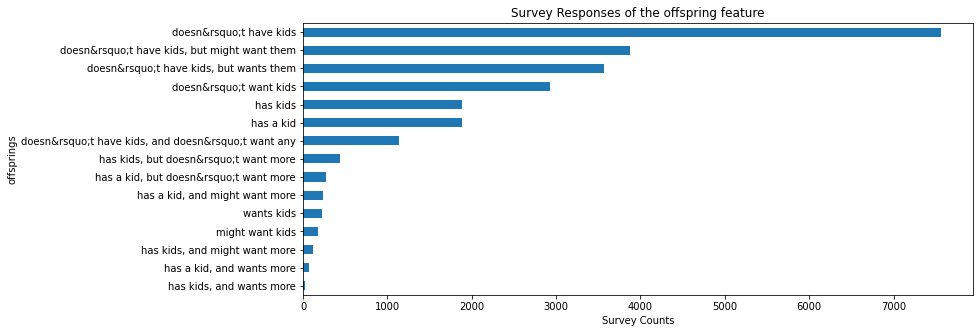

In [53]:
plot_viz(df_copy, 'offspring')

##### **Summary**: Majority of respondents don't have kids
- Create 2 different features
    - Current # of Kids : 0,1, >1
    - (Y/N) Wants more kids

#### Orientation

In [54]:
df_copy['orientation'].value_counts()

straight    51606
gay          5573
bisexual     2767
Name: orientation, dtype: int64

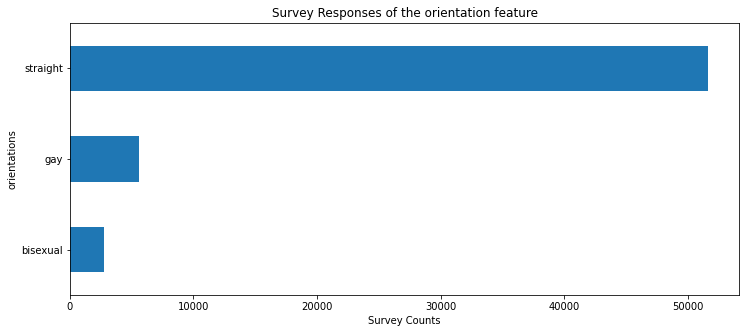

In [55]:
plot_viz(df_copy, 'orientation')

##### **Summary**: Majority of Respondents are HETEROsexual
- (OHE) the 3 categories

#### Pets

In [56]:
df_copy['pets'].value_counts()

likes dogs and likes cats          14814
likes dogs                          7224
likes dogs and has cats             4313
has dogs                            4134
has dogs and likes cats             2333
likes dogs and dislikes cats        2029
has dogs and has cats               1474
has cats                            1406
likes cats                          1063
has dogs and dislikes cats           552
dislikes dogs and likes cats         240
dislikes dogs and dislikes cats      196
dislikes cats                        122
dislikes dogs and has cats            81
dislikes dogs                         44
Name: pets, dtype: int64

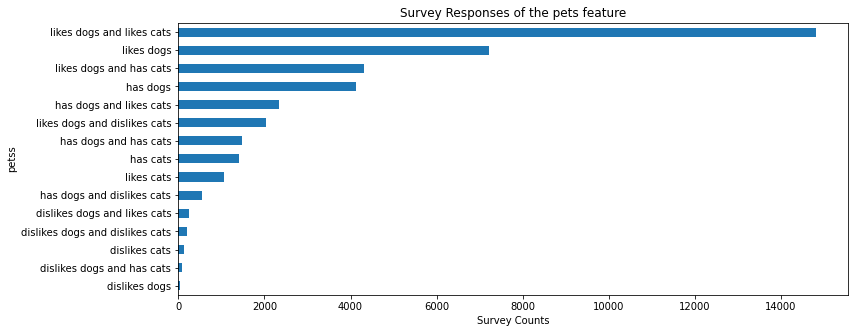

In [57]:
plot_viz(df_copy, 'pets')

##### **Summary**: Majority of respondents like >=1 pets
- Extract 2 different features
    - (Boolean) Likes/ Dislikes pets: If they have a pet then they like animals in general
    - (OHE) Dog, Cat, Both, Neither; preference for a pet

#### Religion

In [58]:
df_copy['religion'].value_counts()

agnosticism                                   2724
other                                         2691
agnosticism but not too serious about it      2636
agnosticism and laughing about it             2496
catholicism but not too serious about it      2318
atheism                                       2175
other and laughing about it                   2119
atheism and laughing about it                 2074
christianity                                  1957
christianity but not too serious about it     1952
other but not too serious about it            1554
judaism but not too serious about it          1517
atheism but not too serious about it          1318
catholicism                                   1064
christianity and somewhat serious about it     927
atheism and somewhat serious about it          848
other and somewhat serious about it            846
catholicism and laughing about it              726
judaism and laughing about it                  681
buddhism but not too serious ab

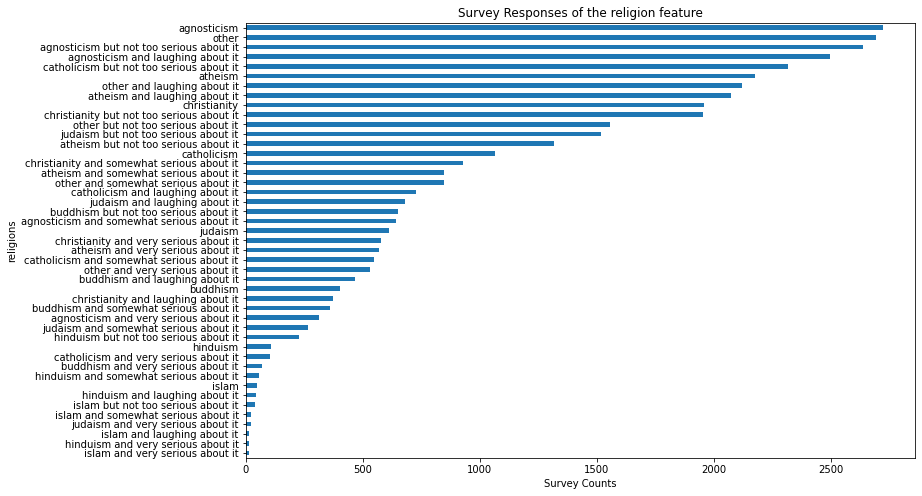

In [59]:
plot_viz(df_copy, 'religion', figsize= (12, 8))

##### **Summary**: Majority of respondents are "not too serious" or "laughing" about their religion
- Extract 2 signals
    - (OE) How Serious they take religion:
        1. Serious
        2. Moderately serious
        3. Not too serious
        4. Laughable
    - (OHE) Actual Religion
        - Catholicism, Agnostic, Hindu, Islam, Christianity, Judaism, Atheism, Buddhism, etc.

#### Sign

In [ ]:
zodiac_list =['Leo', 'Libra', 'Cancer', 'Virgo', 
              'Scorpio', 'Gemini', 'Taurus', 
              'Aries', 'Piscs', 'Aquarius', 
              'Sagittarius', 'Capricorn']

In [60]:
df_copy['sign'].value_counts()

gemini and it&rsquo;s fun to think about         1782
scorpio and it&rsquo;s fun to think about        1772
leo and it&rsquo;s fun to think about            1692
libra and it&rsquo;s fun to think about          1649
taurus and it&rsquo;s fun to think about         1640
cancer and it&rsquo;s fun to think about         1597
pisces and it&rsquo;s fun to think about         1592
sagittarius and it&rsquo;s fun to think about    1583
virgo and it&rsquo;s fun to think about          1574
aries and it&rsquo;s fun to think about          1573
aquarius and it&rsquo;s fun to think about       1503
virgo but it doesn&rsquo;t matter                1497
leo but it doesn&rsquo;t matter                  1457
cancer but it doesn&rsquo;t matter               1454
gemini but it doesn&rsquo;t matter               1453
taurus but it doesn&rsquo;t matter               1450
aquarius but it doesn&rsquo;t matter             1408
libra but it doesn&rsquo;t matter                1408
capricorn and it&rsquo;s fun

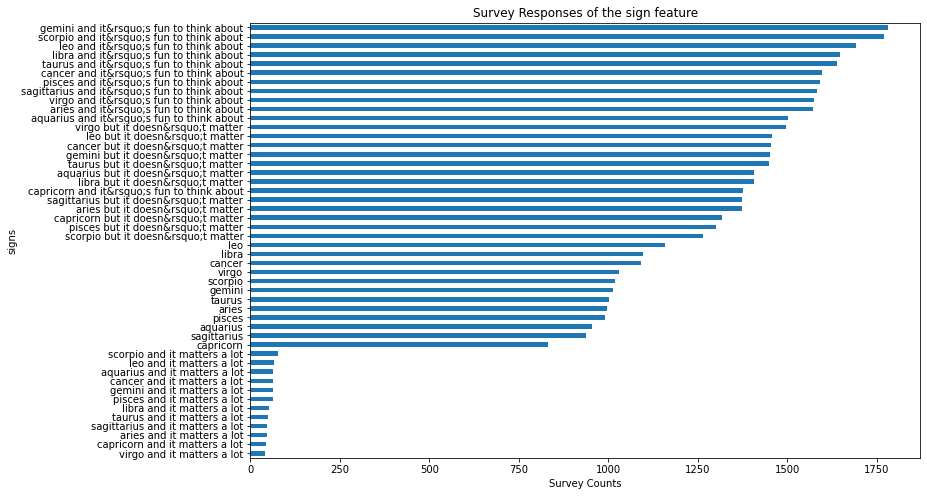

In [61]:
plot_viz(df_copy, 'sign', figsize=(12, 8))

##### **Summary**: Majority of respondants are "ambivalent" of zodiacs or believe they are "fun to think about".
- Extract 2 different signals
    - (OE) Affinity: 
        1. Matters
        2. Fun to Think about
        3. Doesn't matter
    - (OHE) Actual Sign/ Zodiac

#### Smokes

In [62]:
df_copy['smokes'].value_counts()

no                43896
sometimes          3787
when drinking      3040
yes                2231
trying to quit     1480
Name: smokes, dtype: int64

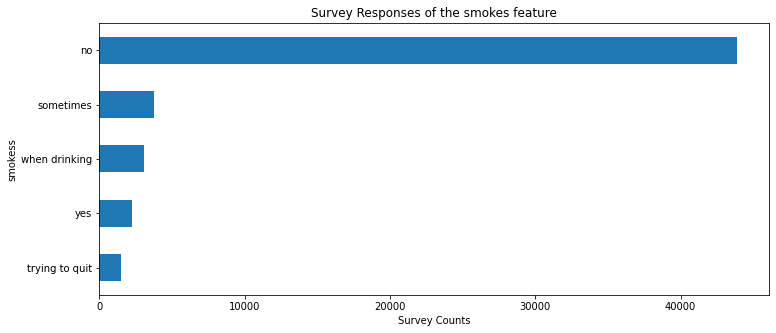

In [63]:
plot_viz(df_copy, 'smokes')

##### **Summary**: Majority of respondents do NOT smoke
- (OHE) Smoking Prefernce
    1. Yes
    2. Sometimes = "sometimes"+ "when drinking" + "trying to quit"
    3. No


#### Speaks

In [64]:
df_copy['speaks'].value_counts().head(30)

english                                                    21828
english (fluently)                                          6628
english (fluently), spanish (poorly)                        2059
english (fluently), spanish (okay)                          1917
english (fluently), spanish (fluently)                      1288
english, spanish                                             859
english (fluently), french (poorly)                          756
english, spanish (okay)                                      655
english, spanish (poorly)                                    609
english (fluently), chinese (fluently)                       535
english (fluently), french (okay)                            532
english (fluently), chinese (okay)                           430
english (poorly)                                             310
english (okay)                                               306
english, chinese                                             306
english (fluently), germa

##### **Summary**: Majority of respondents speak English and are bilingual
- (OHE) Extract 2 features:
    1. Primary Language
    2. Bilingual or better
- If possible take into consideration how many *fluent* languages they speak

#### Status

In [65]:
df_copy['status'].value_counts()

single            55697
seeing someone     2064
available          1865
married             310
unknown              10
Name: status, dtype: int64

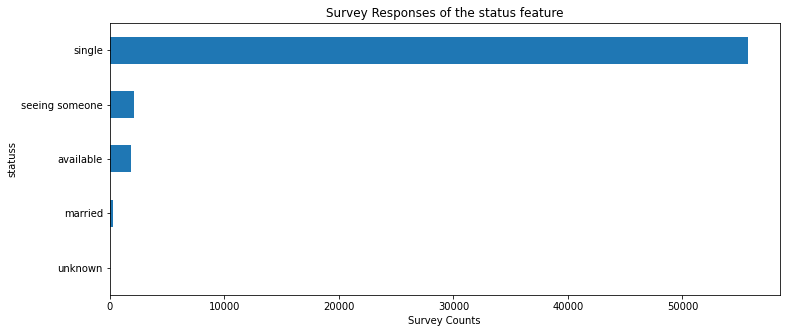

In [66]:
plot_viz(df_copy, 'status')

##### **Summary**: Majority of respondents are single
- single = "single" + available
- Curious to see that people are on the dating app even if they are:
    - "seeing someone" + "married" + "unknown"

### Essay Features


#### Prompts:
- essay0 - My self summary
- essay1 - What I’m doing with my life
- essay2 - I’m really good at
- essay3 - The first thing people usually notice about me
- essay4 - Favorite books, movies, show, music, and food
- essay5 - The six things I could never do without
- essay6 - I spend a lot of time thinking about
- essay7 - On a typical Friday night I am
- essay8 - The most private thing I am willing to admit
- essay9 - You should message me if…


#### Missing data by 'Essay' feature

In [67]:
essay_missing = draw_missing_data_table(df_copy[essay_cols])
essay_missing #sorted by %missing of each essay feature

,feature,total null,% of null values in the column
0,essay8,19225,0.320705
1,essay6,13771,0.229723
2,essay9,12603,0.210239
3,essay7,12451,0.207704
4,essay3,11476,0.191439
5,essay5,10850,0.180996
6,essay4,10537,0.175775
7,essay2,9638,0.160778
8,essay1,7572,0.126314
9,essay0,5488,0.091549


**Summary**: We notice that users *skip later* (higher number) essay questions